# Final Project for INF8225

## InfoGan

#### Bruno Curzi-Laliberté, Thomas Rochefort-Beaudoin, Antoine Martin & Lucas Aubrun

In [1]:
# for Keras
import tensorflow

In [2]:
# for splitting keras Dataset, scikit learn has an easy way: sklearn.model_selection.train_test_split(...)
import sklearn.model_selection

In [3]:
# For creating tensors easily, also includes random tensors with np.random
import numpy as np

In [4]:
# For displaying graphs, MNIST images & GAN images
import matplotlib.pyplot as plt

In [5]:
seed = 8225
batch = 256

In [6]:
# MNIST
(kerasTrainX, kerasTrainY), (kerasTestX, kerasTestY) = tensorflow.keras.datasets.mnist.load_data(path="mnist.npz")
kerasTrainX, kerasValidX, kerasTrainY, kerasValidY = sklearn.model_selection.train_test_split(kerasTrainX, kerasTrainY, test_size=0.1, shuffle=True, random_state=seed)

In [7]:
kerasTrainX = kerasTrainX.reshape(54000, 28, 28, 1)
kerasValidX = kerasValidX.reshape( 6000, 28, 28, 1)
kerasTestX  = kerasTestX.reshape(10000, 28, 28, 1)

In [8]:
# https://github.com/tensorflow/tensorflow/issues/46038
config = tensorflow.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
session = tensorflow.compat.v1.Session(config=config)

In [9]:
# https://stackoverflow.com/a/59568642/10945691
import subprocess as sp
import os

def get_gpu_memory():
    ACCEPTABLE_AVAILABLE_MEMORY = 1024
    COMMAND = "nvidia-smi --query-gpu=memory.free --format=csv"
    memory_free_info = sp.check_output(COMMAND.split()).decode('ascii').split('\n')[1:-1]
    memory_free_values = [int(x.split()[0]) for x in memory_free_info]
    return memory_free_values

# After building 1 model from Keras, this value will drop by 4-5GB, not sure why Keras allocates so much
get_gpu_memory()

[5189]

In [10]:
def Generator():
    generator = tensorflow.keras.models.Sequential()
    # foundation for 7x7 image, not 28x28
    n_nodes = 128 * 7 * 7
    generator.add(tensorflow.keras.layers.Dense(n_nodes, input_dim=10))
    generator.add(tensorflow.keras.layers.LeakyReLU(alpha=0.2))
    generator.add(tensorflow.keras.layers.Reshape((7, 7, 128)))
    # upsample to 14x14
    generator.add(tensorflow.keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    generator.add(tensorflow.keras.layers.LeakyReLU(alpha=0.2))
    # upsample to 28x28
    generator.add(tensorflow.keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    generator.add(tensorflow.keras.layers.LeakyReLU(alpha=0.2))
    generator.add(tensorflow.keras.layers.Conv2D(1, (7,7), activation='sigmoid', padding='same'))
    return generator

In [11]:
def Discriminator():
    discriminator = tensorflow.keras.models.Sequential()
    discriminator.add(tensorflow.keras.layers.Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=(28, 28, 1)))
    discriminator.add(tensorflow.keras.layers.LeakyReLU(alpha=0.2))
    discriminator.add(tensorflow.keras.layers.Dropout(0.4))
    discriminator.add(tensorflow.keras.layers.Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    discriminator.add(tensorflow.keras.layers.LeakyReLU(alpha=0.2))
    discriminator.add(tensorflow.keras.layers.Dropout(0.4))
    discriminator.add(tensorflow.keras.layers.Flatten())
    discriminator.add(tensorflow.keras.layers.Dense(1, activation='sigmoid'))
    opt = tensorflow.keras.optimizers.Adam(lr=0.0002, beta_1=0.5) # 0.5 is interesting
    discriminator.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return discriminator

In [12]:
def GAN(G, D):
    D.trainable = False
    gan = tensorflow.keras.models.Sequential()
    gan.add(G)
    gan.add(D)
    opt = tensorflow.keras.optimizers.Adam(lr=0.0002, beta_1=0.5) # 0.5 is interesting
    gan.compile(loss='binary_crossentropy', optimizer=opt)
    return gan

In [13]:
generator = Generator()

In [14]:
discriminator = Discriminator()

In [15]:
generator.predict(np.zeros((batch, 10))).shape

(256, 28, 28, 1)

In [16]:
discriminator.predict(np.zeros((batch, 28, 28, 1))).shape

(256, 1)

In [17]:
discriminator.predict(generator.predict(np.zeros((batch, 10)))).shape

(256, 1)

In [18]:
gan = GAN(generator, discriminator)

In [19]:
gan.predict(np.zeros((batch, 10))).shape

(256, 1)

In [20]:
for gepoch in range(10):
    print('training discriminator')
    for wsads in range(10):
        genx = generator.predict(np.random.random((batch, 10)))
        datx = kerasTrainX[np.random.randint(0, 54000, batch)]
        discriminator.fit(genx, np.zeros((batch, 1)), batch_size=batch)
        discriminator.fit(datx,  np.ones((batch, 1)), batch_size=batch)
    print('training generator')
    gan.fit(np.random.random((batch, 10)), np.zeros((batch, 1)), verbose=True)

training discriminator
1/1 [==============================] - 0s 9ms/step - loss: 0.3422 - accuracy: 0.9531
training generator
8/8 [==============================] - 1s 13ms/step - loss: 0.7270
training discriminator
1/1 [==============================] - 0s 9ms/step - loss: 0.0100 - accuracy: 0.9922
training generator
8/8 [==============================] - 0s 13ms/step - loss: 0.7009
training discriminator
1/1 [==============================] - 0s 9ms/step - loss: 0.0193 - accuracy: 0.9961
training generator
8/8 [==============================] - 0s 12ms/step - loss: 0.6351
training discriminator
1/1 [==============================] - 0s 11ms/step - loss: 0.0084 - accuracy: 0.9961
training generator
8/8 [==============================] - 0s 15ms/step - loss: 0.5825
training discriminator
1/1 [==============================] - 0s 11ms/step - loss: 0.0783 - accuracy: 0.9883


1/1 [==============================] - 0s 10ms/step - loss: 0.0013 - accuracy: 1.0000
training generator
8/8 [==============================] - 0s 13ms/step - loss: 0.5295
training discriminator
1/1 [==============================] - 0s 9ms/step - loss: 0.0103 - accuracy: 0.9961
training generator
8/8 [==============================] - 0s 12ms/step - loss: 0.4576
training discriminator
1/1 [==============================] - 0s 9ms/step - loss: 2.8326e-06 - accuracy: 1.0000
training generator
8/8 [==============================] - 0s 13ms/step - loss: 0.3419
training discriminator
1/1 [==============================] - 0s 9ms/step - loss: 0.0066 - accuracy: 0.9961
training generator
8/8 [==============================] - 0s 13ms/step - loss: 0.2427
training discriminator
1/1 [==============================] - 0s 10ms/step - loss: 4.4071e-05 - accuracy: 1.0000
training generator


8/8 [==============================] - 0s 13ms/step - loss: 0.1786
training discriminator
1/1 [==============================] - 0s 9ms/step - loss: 1.7192e-04 - accuracy: 1.0000
training generator
8/8 [==============================] - 0s 12ms/step - loss: 0.1286


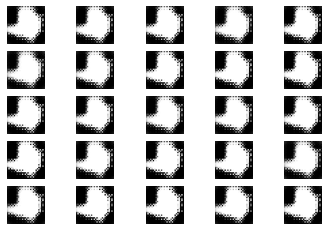

In [21]:
X = generator.predict(np.random.random((25, 10)))
# plot the generated samples
for i in range(25):
	# define subplot
	plt.subplot(5, 5, 1 + i)
	# turn off axis labels
	plt.axis('off')
	# plot single image
	plt.imshow(X[i, :, :, 0], cmap='gray_r')
# show the figure
plt.show()